In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(2, 'h').delta

In [2]:
def get_vol(df):
    return np.sum( np.abs( np.diff(df.BTC.values) ) )

In [3]:
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [4]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.05, 's').delta

min_pos = 0.001

q0 = 5.0

theta_window = pd.Timedelta(0.5, 's').delta

In [5]:
gamma = 0.1

In [6]:
name = ['best price', 'stoikov', 'future', 'furute aggresive', 'future_linear']

In [7]:
s1 = BaseStrategy(delay, min_pos, theta_window, 
                  inventory_policy='aggressive',
                  q0=q0)#best_price стратегия с ликвидацией при выходе за q_0

s2 = StoikovStrategy(delay, min_pos, theta_window, gamma, 
                     theta_policy='spread')#базовая стратегия стоикова

s3 = FutureStrategy(delay, min_pos, theta_window, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='neutral', 
                    q0=q0)#стратегия с future_price, инвентарь не ликвидируем

s4 = FutureStrategy(delay, min_pos, theta_window, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='aggressive', 
                    q0=q0)#стратегия с future_price, ликвидируем инвентарь, как только выходим за пределы q_0

s5 = FutureStrategy(delay, min_pos, theta_window, gamma, md, 
                    theta_policy='spread', 
                    inventory_policy='linear', 
                    q0=q0)#стратегия с future_price, ликвидируем инвентарь

In [8]:
strats = dict(zip(name, [s1, s2, s3, s4, s5]))

In [9]:
def get_info(result : dict, cost):
    pnl = get_pnl( result['update'], cost )
    
    res = dict()
    res['receive_ts'] = result['receive_ts']
    res['ask_price'] = result['ask_price']
    res['bid_price'] = result['bid_price']
    res['mid_price'] = result['mid_price']
    return pnl, pd.DataFrame(res)

In [10]:
pnls = {}
dfs = {}

for k, s in strats.items():
    r = s.run(Sim(md, latency, md_latency))
    
    pnls[k], dfs[k] = get_info(r, cost=-0.01 / 100 / 100)
    del r

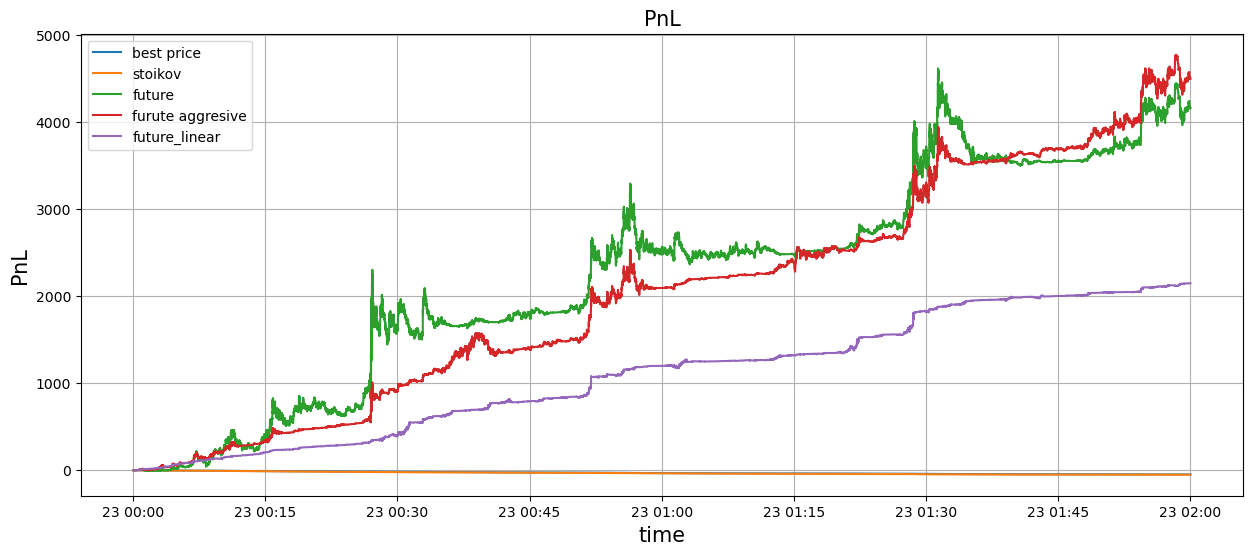

In [11]:
plt.figure(figsize=(15, 6))
for k, df in pnls.items():
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.total, label=k)
plt.legend()
plt.title("PnL", fontsize=15)
plt.xlabel('time', fontsize=15)
plt.ylabel('PnL', fontsize=15)
plt.grid()
plt.show()

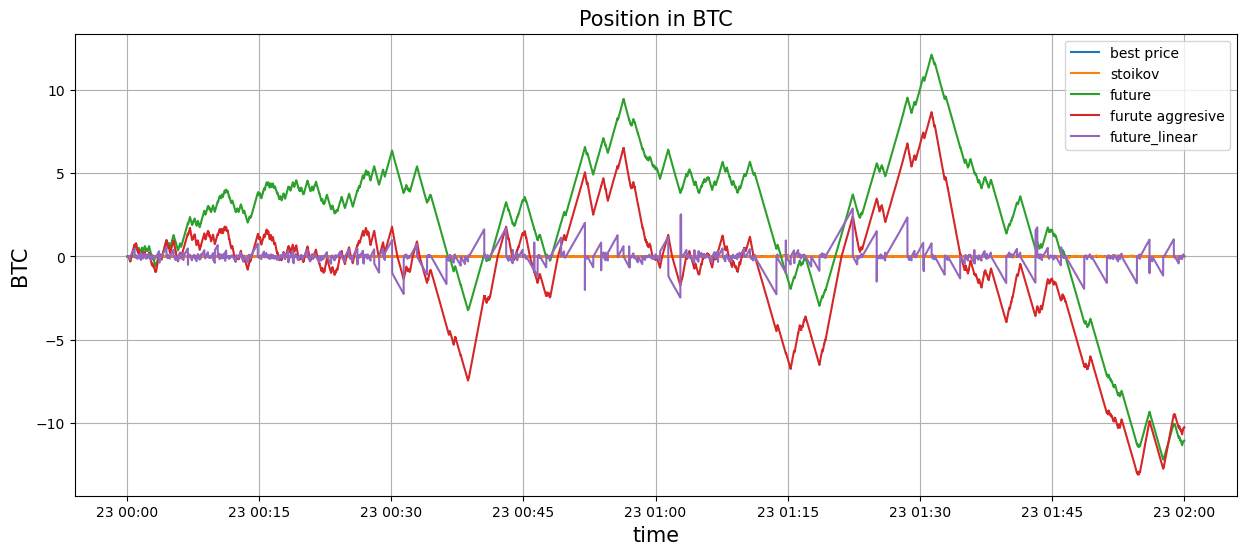

In [12]:
plt.figure(figsize=(15, 6))
for k, df in pnls.items():
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.BTC, label=k)
plt.legend()
plt.title("Position in BTC", fontsize=15)
plt.xlabel('time', fontsize=15)
plt.ylabel('BTC', fontsize=15)
plt.grid()
plt.show()

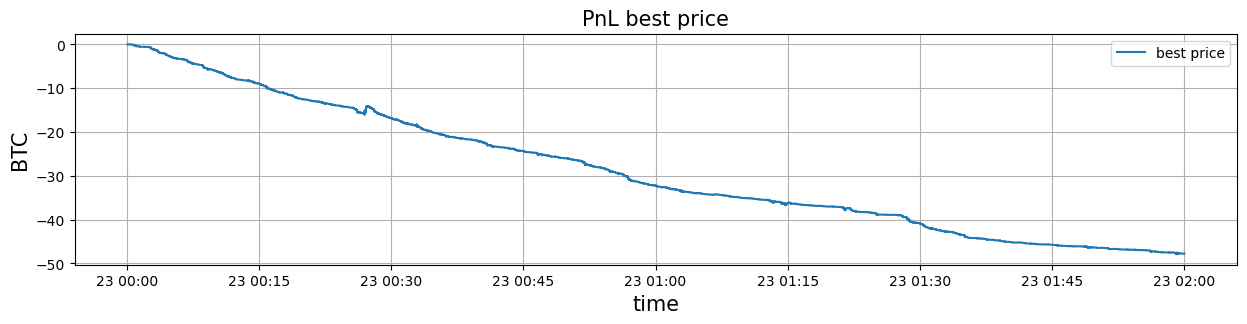

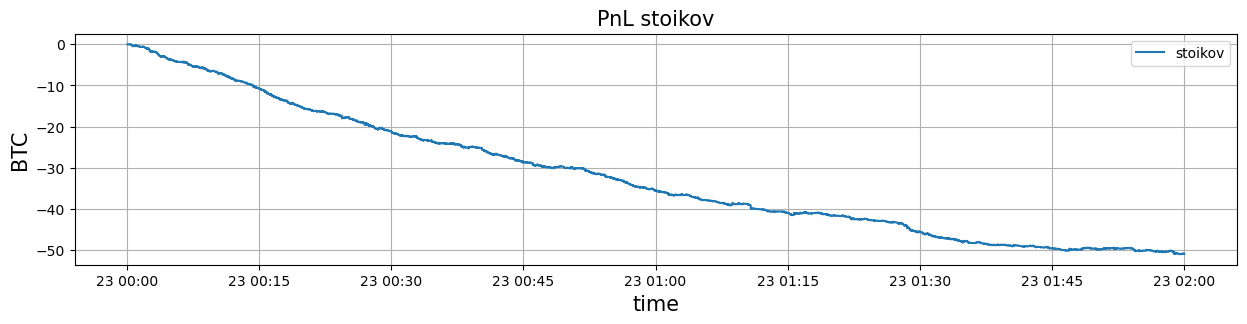

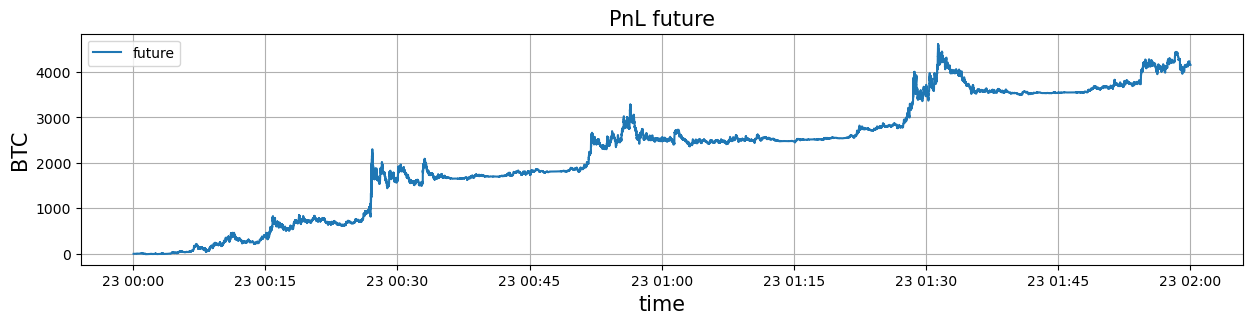

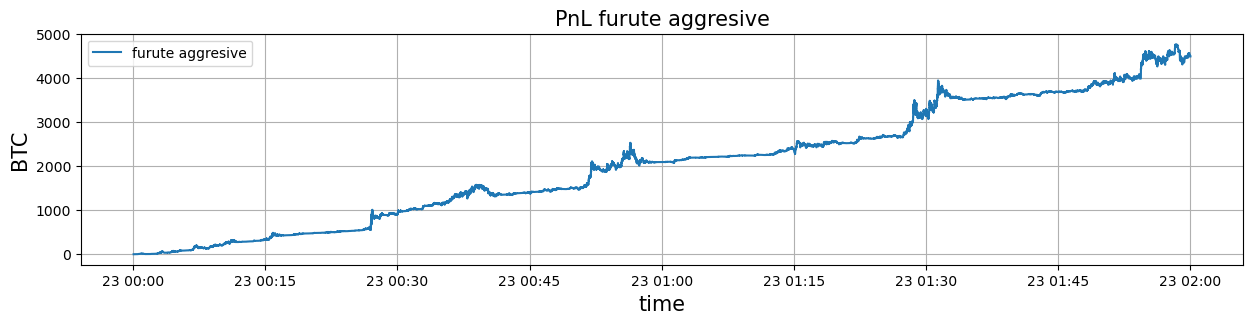

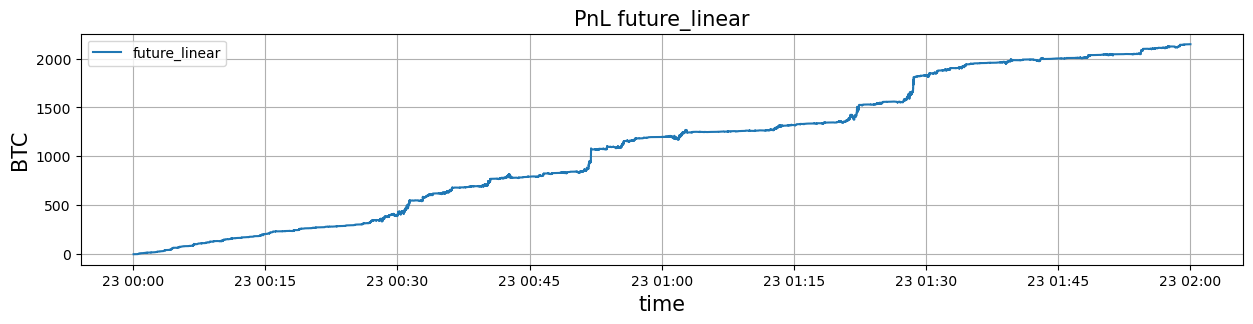

In [13]:
for k, df in pnls.items():
    plt.figure(figsize=(15, 3))
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.total, label=k)
    plt.legend()
    plt.title("PnL " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

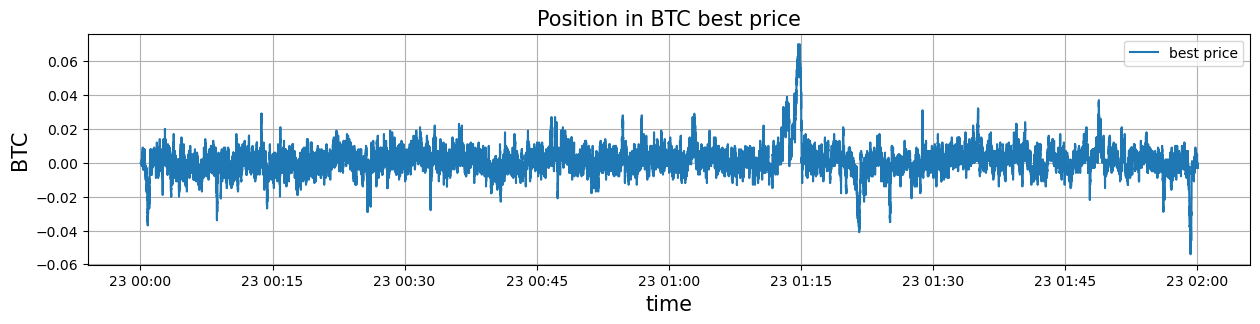

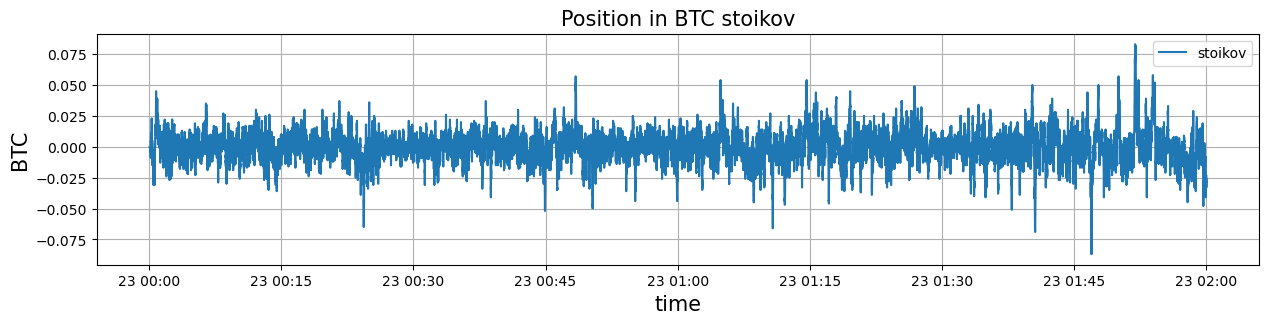

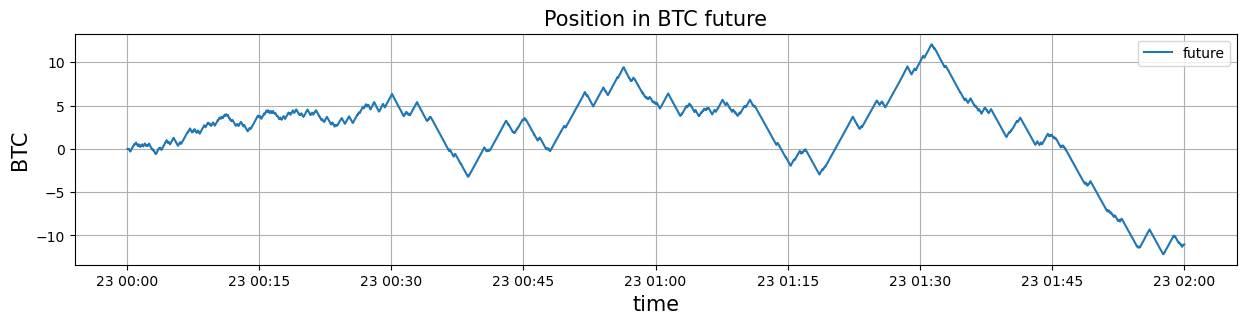

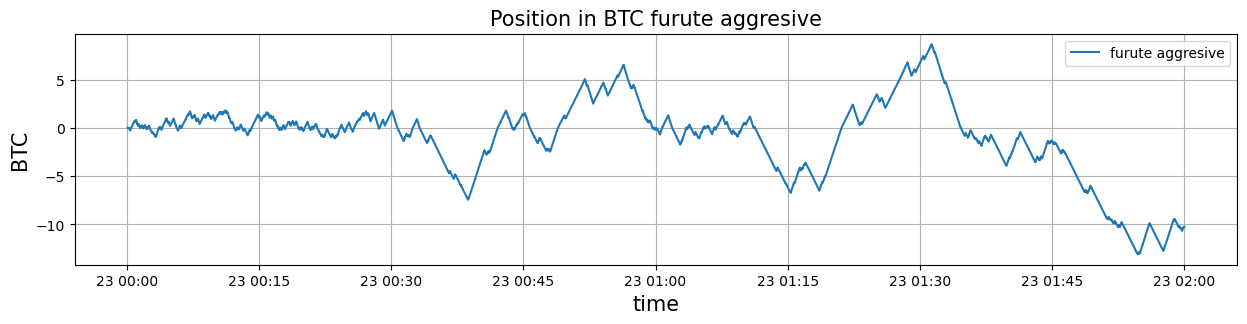

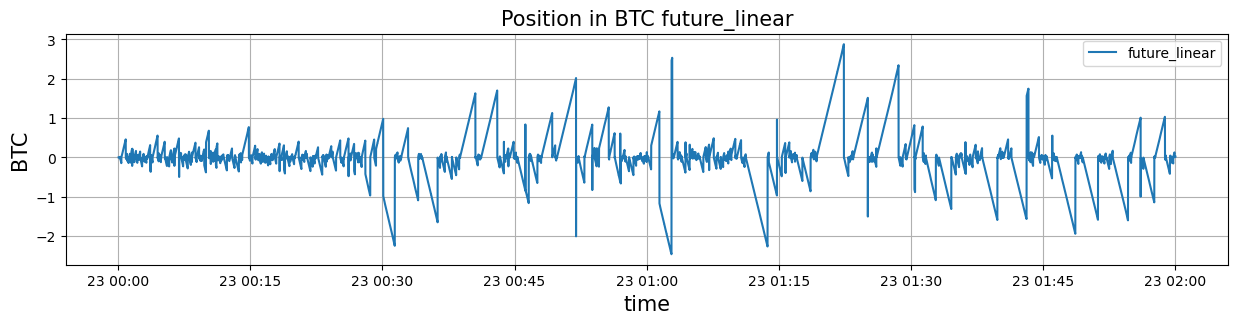

In [14]:
for k, df in pnls.items():
    plt.figure(figsize=(15, 3))
    dt = pd.to_datetime(df.receive_ts)
    plt.plot(dt, df.BTC, label=k)
    plt.legend()
    plt.title("Position in BTC " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

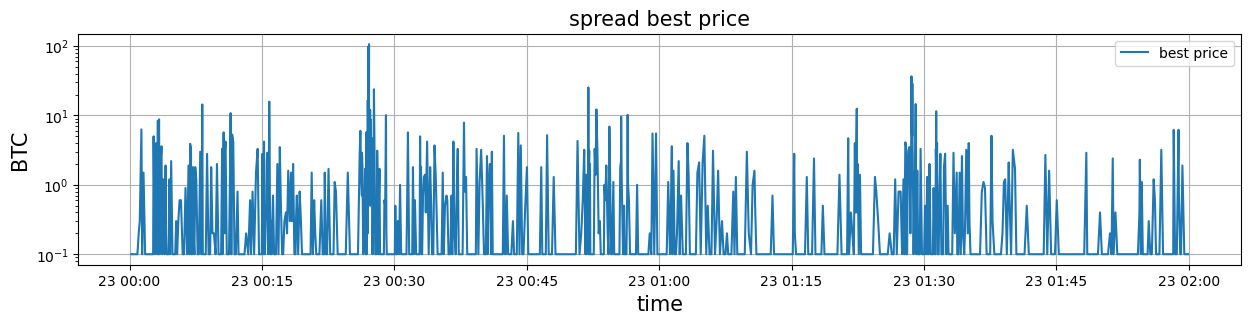

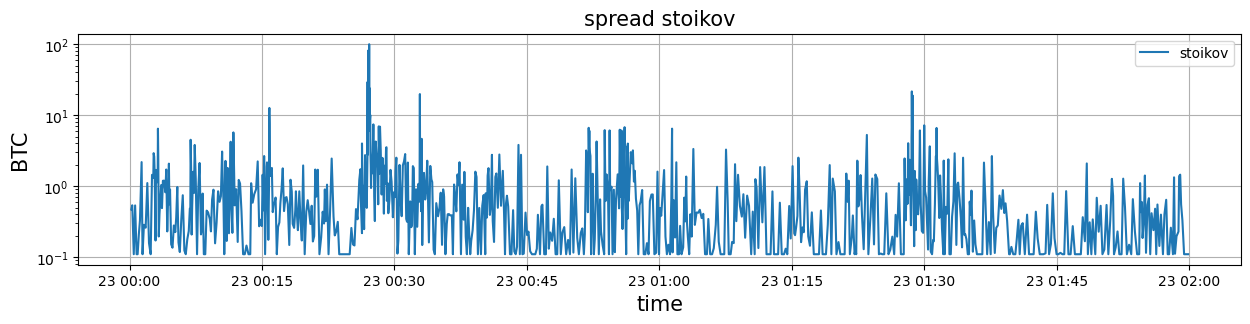

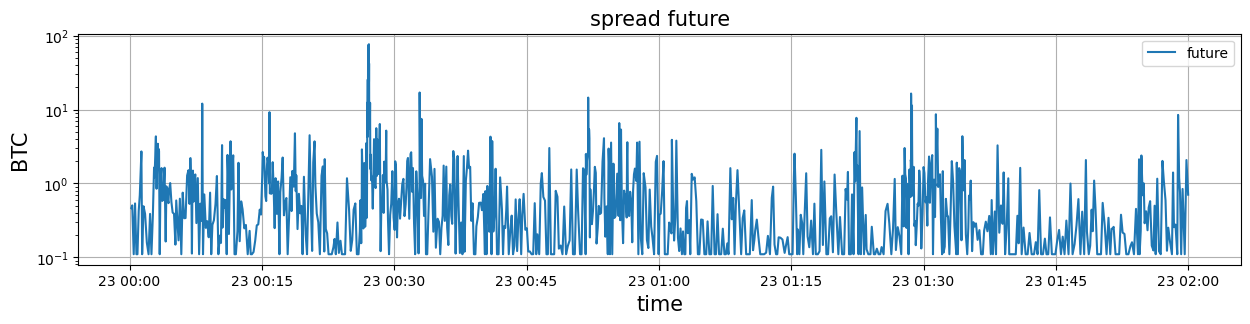

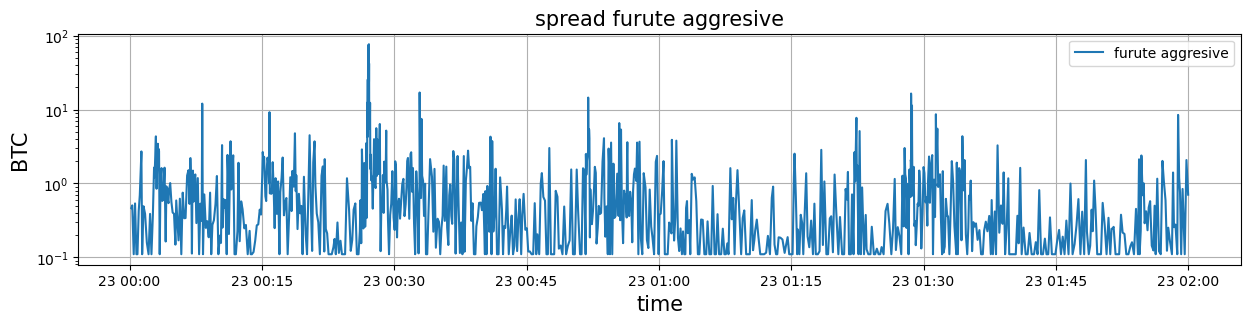

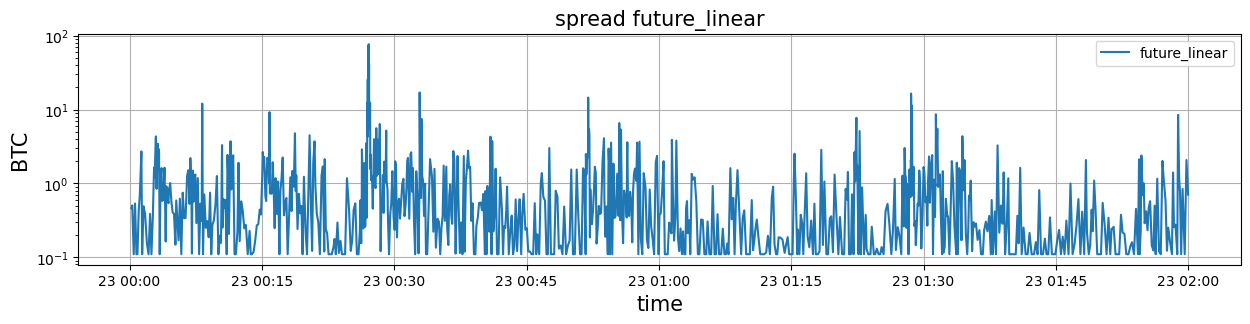

In [15]:
for k, df in dfs.items():
    sl = slice(None, None, 1000)
    plt.figure(figsize=(15, 3))
    spread = (df['ask_price'] - df['bid_price'])[sl]
    dt = pd.to_datetime(df.receive_ts)[sl]
    plt.semilogy(dt, spread, label=k)
    plt.legend()
    plt.title("spread " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

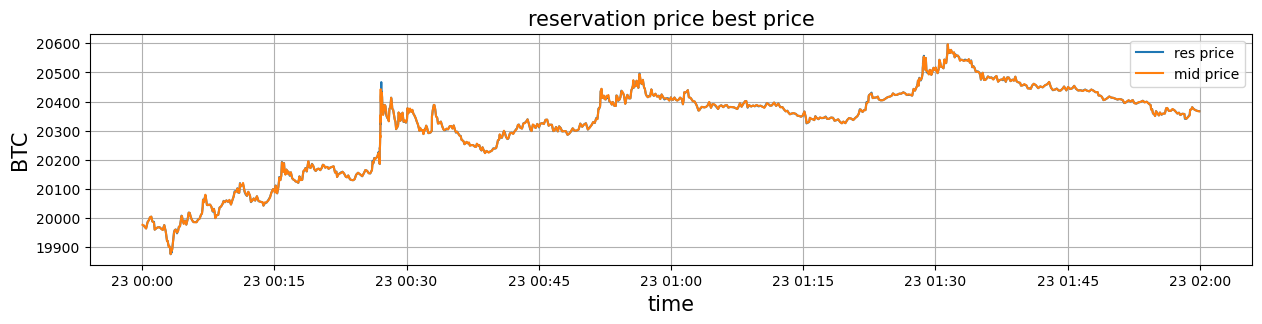

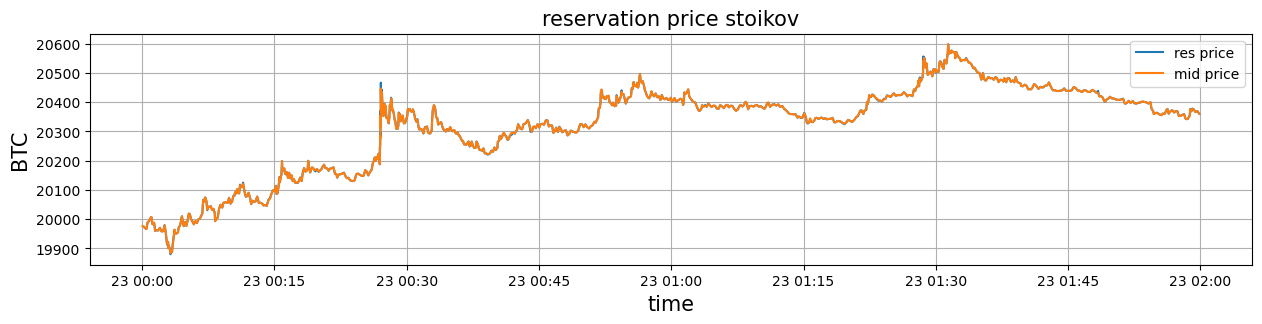

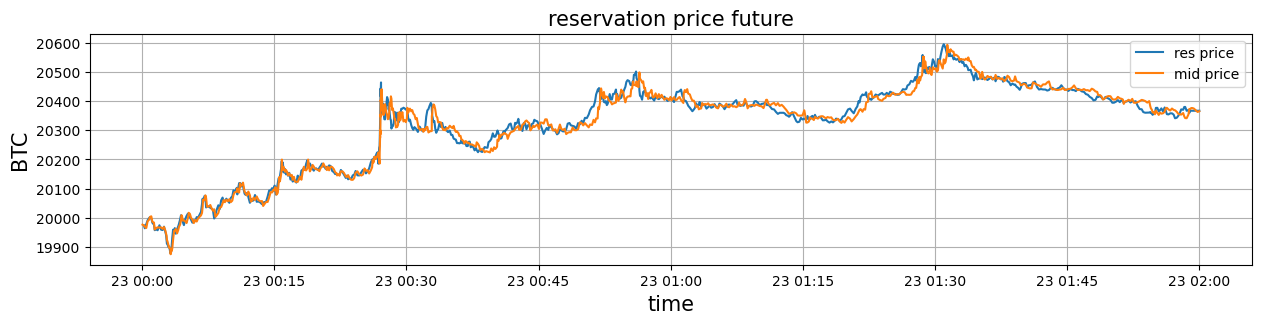

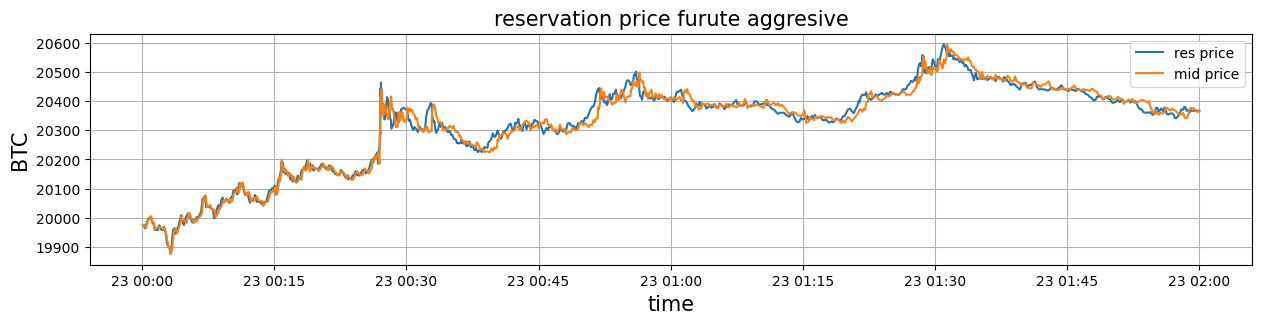

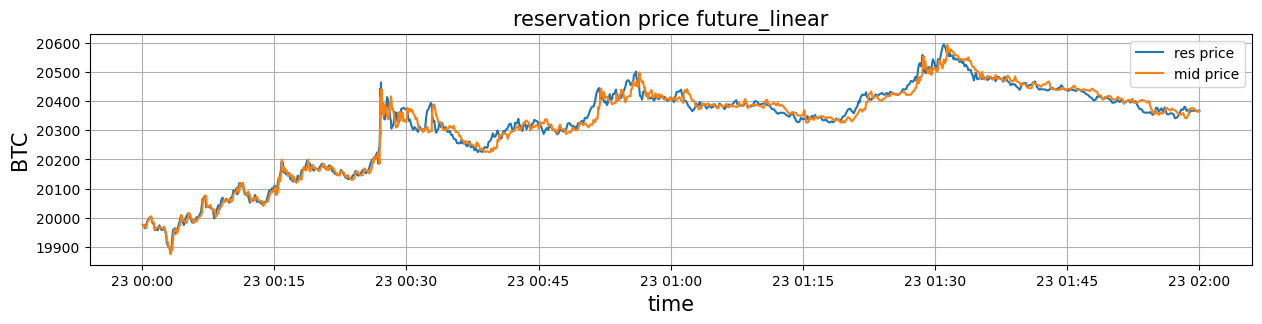

In [16]:
for k, df in dfs.items():
    sl = slice(None, None, 1000)
    plt.figure(figsize=(15, 3))
    res_price = 0.5 * (df['ask_price'] + df['bid_price'])[sl]
    mid_price = df['mid_price'][sl]
    dt = pd.to_datetime(df.receive_ts)[sl]
    plt.plot(dt, res_price, label='res price')
    plt.plot(dt, mid_price, label='mid price')
    plt.legend()
    plt.title("reservation price " + k, fontsize=15)
    plt.xlabel('time', fontsize=15)
    plt.ylabel('BTC', fontsize=15)
    plt.grid()
    plt.show()

Стратегия стоикова(после правильного скейлинга инвентори) хорошо ликвидирует позицию, график её инвентори похож на график best_price стратегии с агресивной политикой ликвидации.

Исправил future_price, теперь берётся время через секунду вперёд. Теперь стратегии на основе future_price зарабатывают. future стратегия не учитывает inventory и видно, что у неё максимальный inventory. в future_inv ведётся 'агрессивная' ликвидация позиции: если выходим за пределы q_0, то делаем несимметричные позы на покупку/продажу. Видно, что такая ликвидация не очень хорошо работает: стратегия всё равно набирает большие позиции. стратегия future_linear использует другую стратегию ликвидации, видно, что она работает лучше.

В общем, видно, что future_price стратегии работают лучше.
Из стратегий ликвидации лучше всего работает линейная, график позиций для этой стратегии изображен ниже.
В стратегии Стоикова inventory болтается вокруг нуля, как и нужно. Для позиций с предиктором это не так, часто набирается большая позиция и не все методы ликвидации одинакого хорошо от неё избавляются.


Спред у всех стратегий одинаковый(кроме best_pos стратегии), так как я беру его из формул Стоикова.

In [17]:
def get_pos(inv):
    ask_pos = 1.0
    
    ask_pos = 1.0
    if inv > q0:
        ask_pos = 1 + inv - q0
    elif inv < -q0:
        ask_pos = 1 + inv + q0
    ask_pos = max(ask_pos, 0.0)

    bid_pos = 1.0
    if inv > q0:
        bid_pos = 1 - (inv - q0)
    elif inv < -q0:
        bid_pos = 1 - (inv + q0)
    bid_pos = max(bid_pos, 0.0)
    
    return ask_pos, bid_pos

In [18]:
inventory = np.linspace(-20, 20, 100)

ask_pos = [get_pos(inv)[0] for inv in inventory]
bid_pos = [get_pos(inv)[1] for inv in inventory]

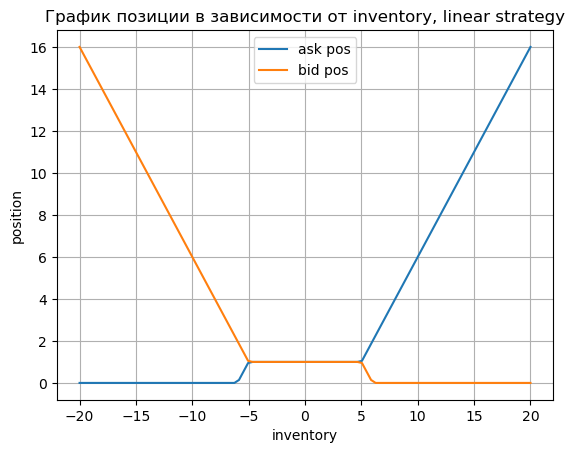

In [19]:
plt.title("График позиции в зависимости от inventory, linear strategy")
plt.plot(inventory, ask_pos, label='ask pos')
plt.plot(inventory, bid_pos, label='bid pos')
plt.grid()
plt.legend()
plt.xlabel("inventory")
plt.ylabel("position")
plt.show()

In [20]:
inventory = np.linspace(-20, 20, 100)

ask_pos = [1.0 + (inv > q0) for inv in inventory]
bid_pos = [1.0 + (inv < -q0) for inv in inventory]

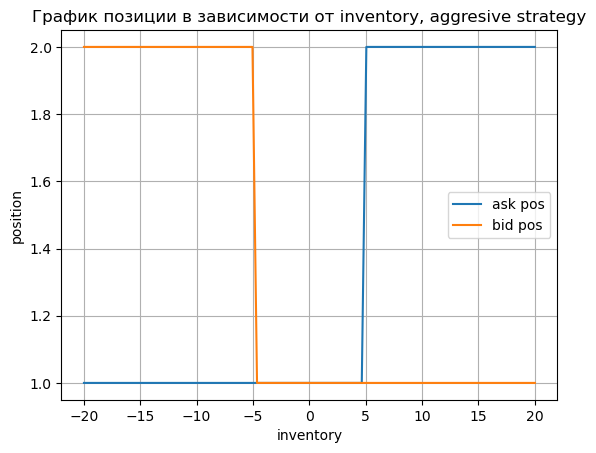

In [21]:
plt.title("График позиции в зависимости от inventory, aggresive strategy")
plt.plot(inventory, ask_pos, label='ask pos')
plt.plot(inventory, bid_pos, label='bid pos')
plt.grid()
plt.legend()
plt.xlabel("inventory")
plt.ylabel("position")
plt.show()